## Librairies

In [1]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import ceil
sns.set_theme()
pd.set_option('display.width', 1000)
# Define the tickers you want to get data for
tickers = ['CL=F', '^STOXX50E', '^TNX', '^GSPC', 'NG=F']

# Define the start and end dates for the data
start_date = '2017-01-01'
end_date = '2022-03-23'

returns = {
  '1d_return' : 1,
  '5d_return' : 5,
  '30d_return' : 30
    
}
output_names = returns.keys()


# Data acquisition

In [3]:
# Use yfinance to get the adjusted price for every tickers
data = yf.download(tickers, start=start_date, end=end_date).loc[:, 'Adj Close'].dropna()

file_path = 'https://raw.githubusercontent.com/CossonArthur/Gas-price-prediction-Statistic/main/NGAS_TS%20-%20Historical%20Data.csv'
data_NGAS = pd.read_csv(file_path, parse_dates=['Date']).set_index('Date')
data_NGAS.rename(columns={'Price': 'NGAS.L'}, inplace=True)

[*********************100%***********************]  5 of 5 completed


In [4]:
data = data.merge(data_NGAS, left_index=True, right_index=True, how='left')
tickers.append('NGAS.L')

We selected a mix of macro, equities and fixed income variables. Eurostoxx and SP500 are the two main equity indices for Europe and US. TNX instead is the reference yield of the US 10 years government bond. The fixed income market is important for commodities pricing as discounting inflation expectations and market risk sentiment. The time series are available in the price domain, so we had to transform into returns at various frequencies. Given the nature of the asset class, we assumed a fixed duration for the 10 year government bond and used a first order linear approximation to estimate returns. For each time series we also calculated a momentum signal through trend filtering. We used for this a simple common used method, which is the difference of two exponentially weighted moving averages with different half lives. This is a simple proxy of the time series gradient and the method is called "moving average crossover".




In the above code: 

1.   CL=F is the ticker symbol for crude oil futures
2.   ^STOXX50E is the ticker symbol for the Euro
3.   Stoxx 50 index
4.   ^TNX is the ticker symbol for the 10-year US Treasury yield
5. ^GSPC is the ticker symbol for the S&P 500 index


## Filling missing data

In [5]:
# here we check for data missing
dates_check = data.reset_index()['Date']

In [6]:
dates_check['check'] =  dates_check.diff()
dates_check['check'].max()

Timedelta('6 days 00:00:00')

##  Features calculation
EMAS, MOMENTUM AND RETURNS




In [7]:
# Calculate the EMAs with half-life of 5, 10, and 30 days
for ticker in tickers:
    if(ticker != 'NGAS.L'):
      data[ticker + '_ema_5'] = data[ticker].ewm(halflife=5).mean()
      data[ticker + '_ema_10'] = data[ticker].ewm(halflife=10).mean()
      data[ticker + '_ema_30'] = data[ticker].ewm(halflife=30).mean()

# Calculate fast and slow momentum for each ticker
for ticker in tickers:
    if(ticker != 'NGAS.L'):
      data[ticker + '_fast_momentum'] = data[ticker + '_ema_5'] - data[ticker + '_ema_10']
      data[ticker + '_slow_momentum'] = data[ticker + '_ema_10'] - data[ticker + '_ema_30']

# Calculate daily, 5-day, and 30-day rolling returns for each ticker
# TODO : handle the creation of data by shrinking the interval by 30 day 
for ticker in tickers:
    if ticker == '^TNX':
        # Calculate returns for ^TNX with a different formula as this is a bond
        for key, val in returns.items():
          data[ticker + '_' + key] = (data[ticker] - data[ticker].shift(val))/100 * -7 
    else:
        #https://www.wikiwand.com/en/Rate_of_return#Logarithmic_or_continuously_compounded_return
        for key, val in returns.items():
          data[ticker + '_' + key] = np.log(data[ticker] / data[ticker].shift(val))

data.dropna(inplace = True)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
data.columns

Index(['CL=F', 'NG=F', '^GSPC', '^STOXX50E', '^TNX', 'NGAS.L', 'CL=F_ema_5', 'CL=F_ema_10', 'CL=F_ema_30', '^STOXX50E_ema_5', '^STOXX50E_ema_10', '^STOXX50E_ema_30', '^TNX_ema_5', '^TNX_ema_10', '^TNX_ema_30', '^GSPC_ema_5', '^GSPC_ema_10', '^GSPC_ema_30', 'NG=F_ema_5', 'NG=F_ema_10', 'NG=F_ema_30', 'CL=F_fast_momentum', 'CL=F_slow_momentum', '^STOXX50E_fast_momentum', '^STOXX50E_slow_momentum', '^TNX_fast_momentum', '^TNX_slow_momentum', '^GSPC_fast_momentum', '^GSPC_slow_momentum', 'NG=F_fast_momentum', 'NG=F_slow_momentum', 'CL=F_1d_return', 'CL=F_5d_return', 'CL=F_30d_return', '^STOXX50E_1d_return', '^STOXX50E_5d_return', '^STOXX50E_30d_return', '^TNX_1d_return', '^TNX_5d_return', '^TNX_30d_return', '^GSPC_1d_return', '^GSPC_5d_return', '^GSPC_30d_return', 'NG=F_1d_return', 'NG=F_5d_return', 'NG=F_30d_return', 'NGAS.L_1d_return', 'NGAS.L_5d_return', 'NGAS.L_30d_return'], dtype='object')

# Data analysis

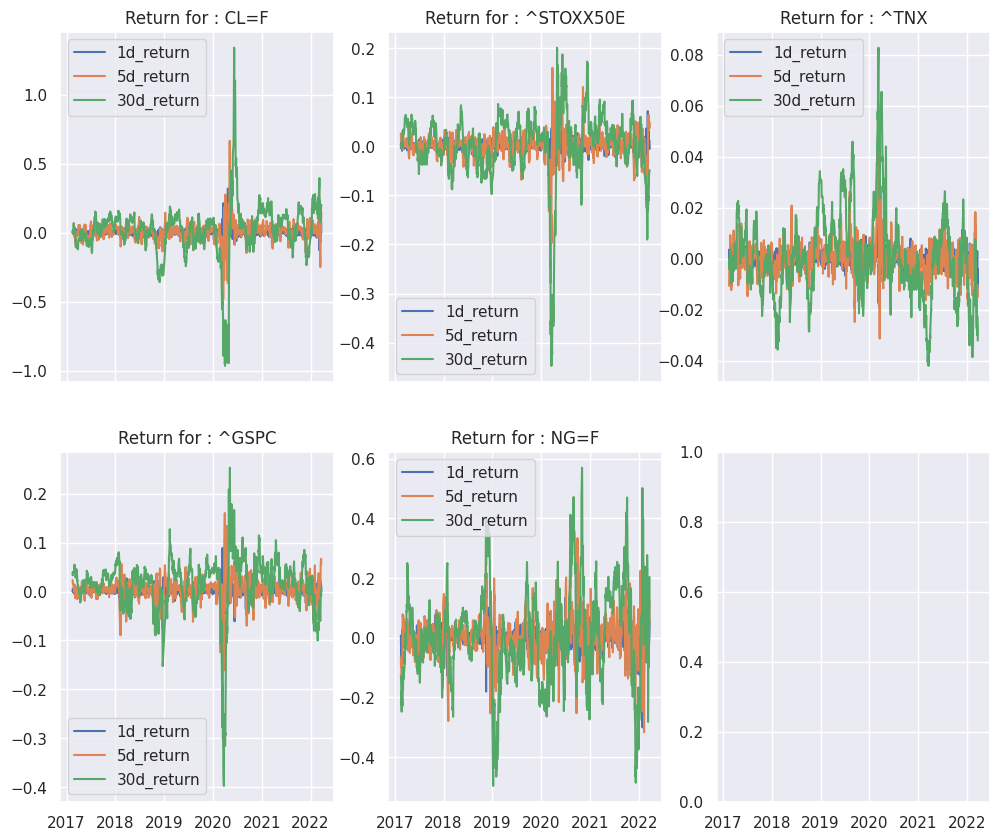

In [21]:
fig, axs = plt.subplots(ceil(len(tickers)/3),3,figsize=(12*ceil(len(tickers)//3), 10),sharex='all')
for i in range(len(tickers)):
  for x in output_names:
    axs[i//3,i%3].plot(data[tickers[i] + '_' + x])
  axs[i//3,i%3].legend(output_names)
  axs[i//3,i%3].set_title('Return for : {}'.format(tickers[i]))


## Time series seasonnal decomposition

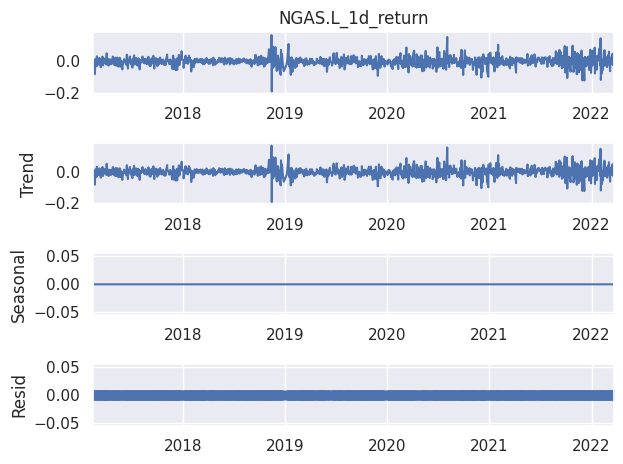

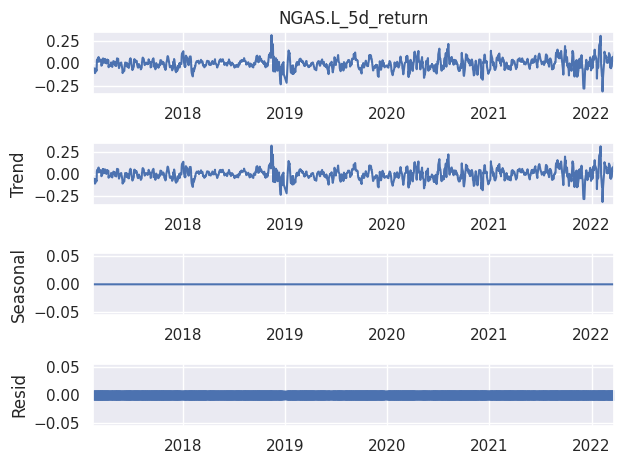

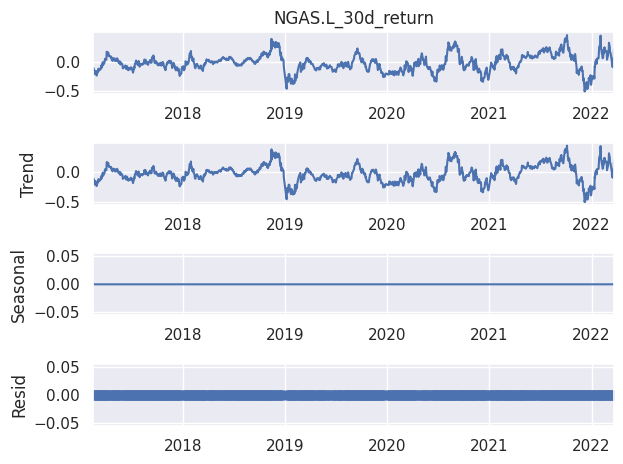

In [31]:
import statsmodels.api as sm

for x in output_names:
  decomposition = sm.tsa.seasonal_decompose(data['NGAS.L_' + x], model = 'additive',period=1)
  decomposition.plot()

## Correlation analysis

In [22]:
#result = pg.pairwise_corr(data)
#print(result)

#print(data.pcorr().round(3))

df = data.rcorr(decimals=2,upper='n',method='spearman').replace(['-',data.shape[0]],0).astype('float')
px.imshow(df)



## Normality test

                                W          pval  normal
CL=F                     0.978031  9.373793e-13   False
NG=F                     0.894183  2.673999e-28   False
^GSPC                    0.876768  3.702178e-30   False
^STOXX50E                0.960733  9.991197e-18   False
^TNX                     0.956661  1.162803e-18   False
NGAS.L                   0.939057  4.334492e-22   False
CL=F_ema_5               0.982843  6.547083e-11   False
CL=F_ema_10              0.988624  3.336261e-08   False
CL=F_ema_30              0.985417  8.718414e-10   False
^STOXX50E_ema_5          0.949426  3.557813e-20   False
^STOXX50E_ema_10         0.936749  1.755152e-22   False
^STOXX50E_ema_30         0.887022  4.324378e-29   False
^TNX_ema_5               0.952562  1.537409e-19   False
^TNX_ema_10              0.949561  3.784787e-20   False
^TNX_ema_30              0.937681  2.521079e-22   False
^GSPC_ema_5              0.871779  1.185876e-30   False
^GSPC_ema_10             0.868406  5.601207e-31 

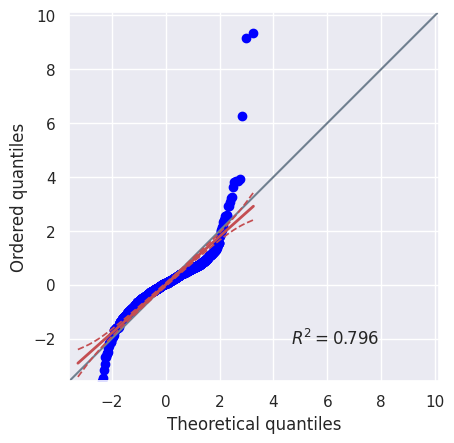

In [23]:
result = pg.normality(data)
print(result)
#ax = pg.qqplot(data['CL=F_5d_return'], dist='norm')
ax = pg.qqplot(data['CL=F_5d_return'], dist='norm')

## Plot

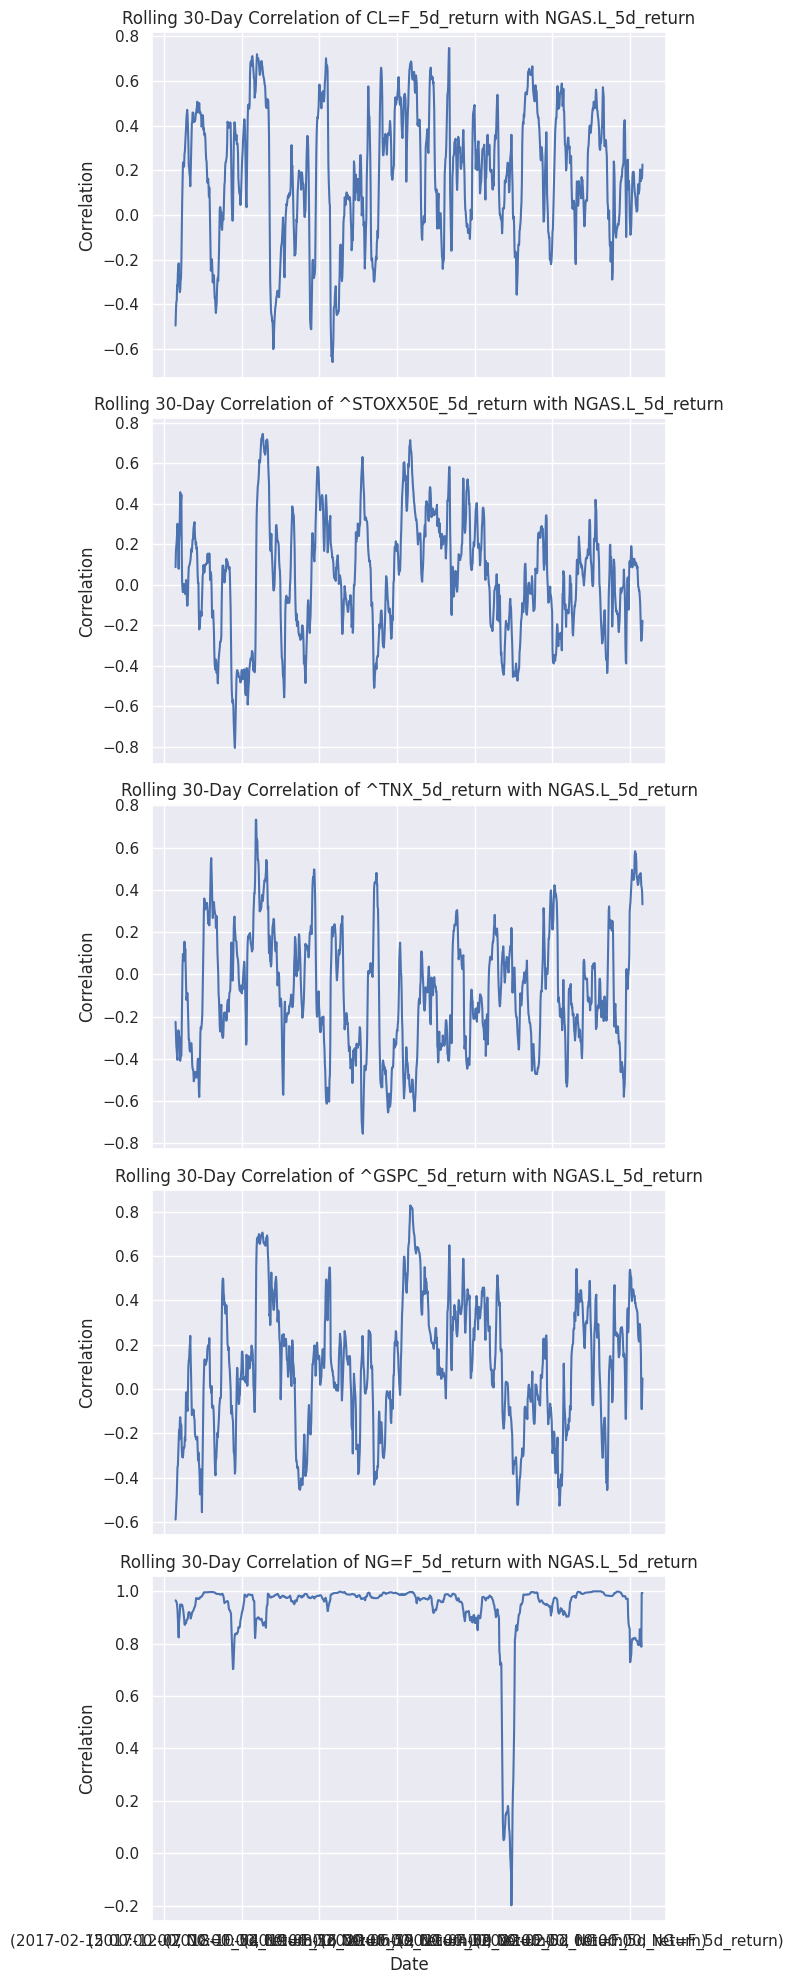

In [24]:
# Get the columns with '5d_return' in the name, excluding 'NGAS.L_5d_return'
cols_5d_return = [col for col in data.columns if '5d_return' in col and col != 'NGAS.L_5d_return']

# Calculate the rolling correlation with a window of 30 days for each column against 'NGAS.L_5d_return'
rolling_correlations = data[cols_5d_return + ['NGAS.L_5d_return']].rolling(window=30).corr()

# Determine the number of subplots required
num_subplots = len(cols_5d_return)

# Set up the subplots with the desired size
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 4 * num_subplots), sharex=True)

# Plot each rolling correlation in a separate subplot
for idx, col in enumerate(cols_5d_return):
    rolling_correlations.loc[pd.IndexSlice[:, col], 'NGAS.L_5d_return'].plot(ax=axes[idx])
    axes[idx].set_title(f'Rolling 30-Day Correlation of {col} with NGAS.L_5d_return')
    axes[idx].set_ylabel('Correlation')

plt.xlabel('Date')
plt.tight_layout()




## PCA


In [25]:
input_columns = [col for col in data.columns if not('NGAS' in col)]
X = data[input_columns]

print('Number of initial features : {}'.format(len(input_columns)))

Number of initial features : 45


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA()
X_hat = pca.fit_transform(X)

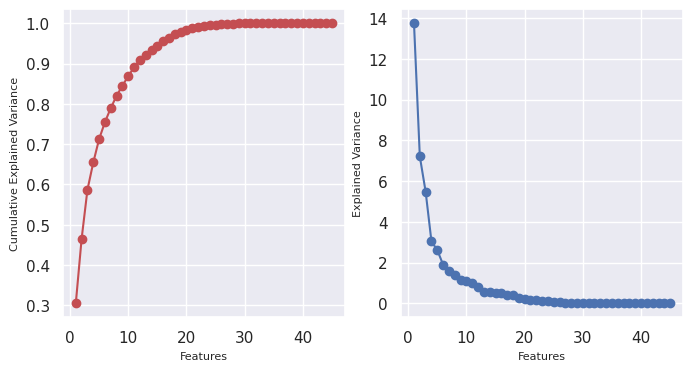

In [27]:
prop_var = pca.explained_variance_ratio_

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(range(1,len(prop_var)+1),np.cumsum(prop_var), 'ro-')
axs[0].set_xlabel('Features', fontsize=8)
axs[0].set_ylabel('Cumulative Explained Variance', fontsize=8)
axs[1].plot(range(1,len(prop_var)+1),pca.explained_variance_,'bo-')
axs[1].set_ylabel('Explained Variance', fontsize=8)
axs[1].set_xlabel('Features', fontsize=8)
plt.show()

In [16]:
def biplot(score,coef,labels=None,represent = None):
  
    if (represent != None):
       labels = [ticker if ticker in represent else ' ' for ticker in labels]

    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,
                s=5, 
                color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
 
    plt.figure()

InvalidIndexError: ignored

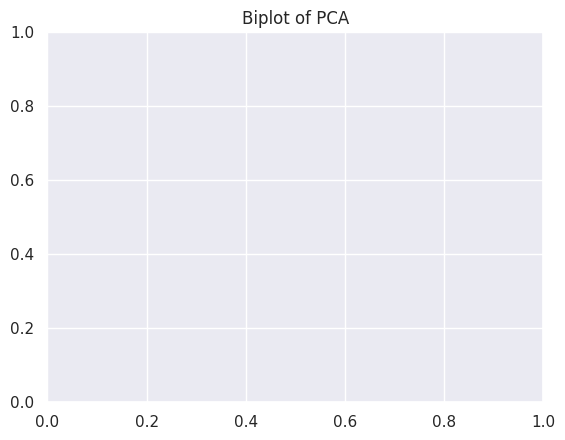

In [113]:
plt.title('Biplot of PCA')
 
biplot(X_hat, np.transpose(pca.components_), input_columns,tickers)

## Principal components selection

In [35]:
#@title PAC limit choice
max_component = 12 #@param {type:"slider", min:0, max:45, step:1}


print('Amount of variance explained by the choice of principal components : {}'.format(round(np.sum(prop_var[:max_component+1]),3)))

weights = pd.DataFrame(np.transpose(pca.components_), index=input_columns)
fig = px.bar(weights.loc[:,:max_component],title="Weight")
fig.show() # double clicked on a component in the legend to isolate


Amount of variance explained by the choice of principal components : 0.921


# Classification models 



##Data preprocessing

In [29]:
X_hat = pd.DataFrame(X_hat).loc[:,:max_component]
X_hat.describe() # input vector

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03,1234.000000,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03,1.234000e+03
mean,9.212872e-17,-1.842574e-16,-1.842574e-16,-2.015316e-17,3.454827e-17,0.000000,5.758045e-18,-1.151609e-17,3.454827e-17,2.303218e-17,5.182240e-17,1.151609e-17,1.727413e-17
std,3.708526e+00,2.685474e+00,2.340759e+00,1.742522e+00,1.616239e+00,1.375889,1.252398e+00,1.172776e+00,1.061323e+00,1.035479e+00,9.876464e-01,9.042027e-01,7.545762e-01
min,-9.396804e+00,-8.283406e+00,-3.992089e+00,-7.521677e+00,-7.326762e+00,-4.523283,-4.996623e+00,-5.599668e+00,-6.930185e+00,-4.066612e+00,-5.768357e+00,-4.089916e+00,-3.494941e+00
25%,-9.531628e-01,-1.420268e+00,-1.656718e+00,-7.692069e-01,-7.498826e-01,-0.806542,-6.036072e-01,-6.132745e-01,-4.944273e-01,-6.608510e-01,-6.002077e-01,-5.579977e-01,-4.689051e-01
50%,8.000949e-01,4.084133e-01,-4.425424e-01,2.847472e-02,-5.795264e-02,-0.067630,1.209572e-01,-9.871777e-02,7.062621e-03,-2.474165e-02,-2.854614e-02,-4.457887e-02,-5.332716e-02
75%,1.984228e+00,1.775686e+00,1.289938e+00,8.472212e-01,7.774343e-01,0.715305,7.391336e-01,4.258417e-01,4.960041e-01,6.235034e-01,5.463892e-01,4.914705e-01,4.541574e-01
max,1.149633e+01,9.064285e+00,1.251279e+01,1.260327e+01,7.479725e+00,8.233612,9.569852e+00,7.801405e+00,6.941895e+00,6.725347e+00,7.039370e+00,5.312393e+00,5.695292e+00


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Y = data[[col for col in data.columns if ('NGAS' in col)]] #target vector
Y_class =  pd.DataFrame() # target vector for class 


for x in output_names:
  Y_class[x] = np.where(Y['NGAS.L_' + x] >= Y['NGAS.L_' + x].quantile(0.75),'High Profit', 
                        np.where(Y['NGAS.L_' + x] >= Y['NGAS.L_' + x].quantile(0.5),'Marginal Profit',     
                            np.where(Y['NGAS.L_' + x] >= Y['NGAS.L_' + x].quantile(0.25),'Marginal Loss', 'High loss')
                        )
              )

for x in output_names:
  Y_class[x] = np.where(Y['NGAS.L_' + x] >= Y['NGAS.L_' + x].std(),'High Profit', 
                        np.where(Y['NGAS.L_' + x] >= 0,'Marginal Profit',     
                            np.where(Y['NGAS.L_' + x] >= -Y['NGAS.L_' + x].std(),'Marginal Loss', 'High loss')
                        )
              )

print(pd.concat([Y_class[x].value_counts() for x in output_names],axis=1))

# Encode target classes as numerical labels
le = LabelEncoder()
Y_class_encoded = np.transpose(np.array([le.fit_transform(Y_class[x]) for x in Y_class.columns]))
target_names = le.classes_

# Split data into training and testing sets
X_train, X_test, Y_train_class, Y_test_class = train_test_split(X_hat, Y_class_encoded, test_size=0.2, random_state=17)


                 1d_return  5d_return  30d_return
Marginal Profit        489        473         357
Marginal Loss          478        451         510
High loss              144        171         207
High Profit            123        139         160


## Prediction 

### Random Forest

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Define class weights
class_weights = {0: 0.5,1: 1, 2: 0.5, 3: 1}

for i in range(Y_class.shape[1]):
  # Train a random forest classifier on the training set
  rfc = RandomForestClassifier(n_estimators=300, random_state=42, class_weight=class_weights)
  rfc.fit(X_train, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = rfc.predict(X_test)

  # Print classification report
  print(output_names[i])
  print('-'*60)
  print(classification_report(Y_test_class[:,i], Y_pred, target_names=target_names))
  print('='*60)



daily_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.63      0.44      0.52        27
      High loss       0.75      0.36      0.49        33
  Marginal Loss       0.57      0.72      0.63        88
Marginal Profit       0.64      0.66      0.65        99

       accuracy                           0.62       247
      macro avg       0.65      0.55      0.57       247
   weighted avg       0.63      0.62      0.61       247

5d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.52      0.55      0.54        20
      High loss       0.60      0.39      0.48        38
  Marginal Loss       0.61      0.67      0.64        92
Marginal Profit       0.70      0.71      0.70        97

       accuracy                           0.64       247
      macro avg       0.61      0.58      0.59      

**Metrics and definition** 
* **Precision** ->	Precision is defined as the ratio of true positives to the sum of true and false positives.
* **Recall** ->	Recall is defined as the ratio of true positives to the sum of true positives and false negatives.
* **F1 Score**	-> The F1 is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.
* **Support** ->	Support is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.


### Probabilistic discriminative approach: Logistic Regression

Let us change the methods for the classification task and use a Logistic regression classifier with two classes:
- Hypothesis space: $y_n = y(x_n) = \sigma(w_0 + x_{n1} w_1 + x_{n2} w_2)$;
- Loss measure: Loglikelihood $L(\mathbf{w}) = -\sum_{n=1}^N  [C_n \ln y_n + (1 - C_n) \ln (1 - y_n)]$;
- Optimization method: Gradient Descent;

where the sigmoid function is defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$.
* Pros:
  * Can be simpler and faster to train, since it only needs to estimate the conditional distribution of the labels given the features.
  * May be more effective at capturing the decision boundaries between classes, since it focuses on modeling the conditional distribution of the labels.
  * Can be more interpretable, since it provides a clear probabilistic interpretation of the classification decision.
* Cons:
  * Can be less robust to missing data and noisy data, since it only models the conditional distribution of the labels given the features.
  * May be more prone to overfitting, since it only models the conditional distribution of the labels given the features and may not capture the full distribution of the data.




In [142]:
from sklearn.linear_model import LogisticRegression

for i in range(Y_class.shape[1]):
  # Train a Logistic Regression classifier on the training set
  log_classifier = LogisticRegression(penalty=None) # regularization is applied as default
  log_classifier.fit(X_train, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = log_classifier.predict(X_test)

  # Print classification report
  print(output_names[i])
  print('-'*60)
  print(classification_report(Y_test_class[:,i], Y_pred, target_names=target_names))
  print('='*60)

daily_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.80      0.44      0.57        27
      High loss       0.95      0.58      0.72        33
  Marginal Loss       0.72      0.72      0.72        88
Marginal Profit       0.67      0.84      0.74        99

       accuracy                           0.72       247
      macro avg       0.78      0.64      0.69       247
   weighted avg       0.74      0.72      0.71       247

5d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.47      0.40      0.43        20
      High loss       0.64      0.47      0.55        38
  Marginal Loss       0.62      0.66      0.64        92
Marginal Profit       0.68      0.73      0.71        97

       accuracy                           0.64       247
      macro avg       0.60      0.57      0.58      

### Probabilistic generative approach: Naive Bayes


Generative models have the purpose of modeling the joint pdf of the couple input/output $p(C_k,\mathbf{x})$, which allows us to generate also **new data** from what we learned.

This is different from the probabilistic discriminative models, in which we are only interested in computing the probabilities that a given input is coming from a specific class $p(C_k | \mathbf{x})$, which is not sufficient to produce new samples.

Conversely, we will see how it is possible to generate new samples if we are provided with an approximation of the joint input/output distribution $p(C_k,\mathbf{x})$.

In this case, the Naive Bayes method considers the **naive assumption** that each input is conditionally (w.r.t. the class) independent from each other.
If we consider the Bayes formula we have: 
\begin{align*}
	& p(C_k | \mathbf{x}) = \frac{p(C_k) \ p(\mathbf{x} | C_k)}{p(\mathbf{x})} \\
	& \propto p(x_1, \ldots, x_M, C_k)\\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2, \ldots, x_M, C_k) \\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2 | x_3, \ldots, x_M, C_k) p(x_3, \ldots, x_n, C_k) \\
	& = p(x_1 \vert x_2, \ldots, x_M, C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(x_1 \vert C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(C_k) \prod_{j=1}^M p(x_j | C_k).
\end{align*}

The decision function, which maximises the Maximum A Posteriori probability, is the following:
\begin{equation*}
	y(\mathbf{x}) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k),
\end{equation*}
where as usual we do not consider the normalization factor $p(\mathbf{x})$.

In a specific case we have to define a prior distribution for the classes $p(C_k) \ \forall k$ and a distribution to compute the likelihood of the considered samples $p(x_j | C_k) \ \forall J, \ \forall k$.

In the case of continuous variable one of the usual assumption is to use Gaussian distributions for each variable $p(x_j | C_k) = \mathcal{N}(x_j;\mu_{jk},\sigma^2_{jk})$ and either a uniform prior $p(C_k) = \frac{1}{K}$ or a multinomial prior based on the samples proportions $p(C_k) = \frac{\sum_{i=1}^N I \{\mathbf{x}_n \in C_k \}}{N}$, where $I\{\cdot\}$ is the indicator function.

The complete model of Naive Bayes is:
- Hypothesis space: $y_n = y(x_n) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k)$;
- Loss measure: Log likelihood;
- Optimization method: MLE.

* Pros:
 * Can handle missing data and noisy data well, since it models the joint distribution of features and labels.
  * Can be more robust to overfitting, since it estimates the full distribution of the data rather than just the conditional distribution of the labels.
  * Can be useful for generating synthetic data that follows the same distribution as the training data.
* Cons:
  * Can be computationally more expensive, since it involves estimating the joint distribution.
  * Can suffer from the curse of dimensionality when dealing with high-dimensional feature spaces.
  * May not be as good at capturing the subtle decision boundaries between classes, since it models the distribution of the data as a whole rather than just the boundaries between classes.
 

In [143]:
from sklearn.naive_bayes import GaussianNB

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  gnb_classifier = GaussianNB()
  gnb_classifier.fit(X_train, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = gnb_classifier.predict(X_test)

  # Print classification report
  print(output_names[i])
  print('-'*60)
  print(classification_report(Y_test_class[:,i], Y_pred, target_names=target_names))
  print('='*60)

daily_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.29      0.41      0.34        27
      High loss       0.38      0.27      0.32        33
  Marginal Loss       0.64      0.48      0.55        88
Marginal Profit       0.59      0.71      0.64        99

       accuracy                           0.53       247
      macro avg       0.47      0.47      0.46       247
   weighted avg       0.54      0.53      0.53       247

5d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.23      0.35      0.28        20
      High loss       0.47      0.37      0.41        38
  Marginal Loss       0.59      0.66      0.63        92
Marginal Profit       0.68      0.59      0.63        97

       accuracy                           0.56       247
      macro avg       0.49      0.49      0.49      

### Ovrersampling (meh)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the oversampling to the training data
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, Y_train_class)

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Encode target classes as numerical labels
le = LabelEncoder()
target_class_encoded = le.fit_transform(target_class ['30d'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_20_features, target_class_encoded, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier on the training set
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gnb_classifier.predict(X_test)

# Print classification report
target_names = le.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

      High Loss       0.81      0.53      0.64        83
    High Profit       0.79      0.70      0.74        64
  Marginal Loss       0.41      0.80      0.54        54
Marginal Profit       0.44      0.31      0.36        49

       accuracy                           0.59       250
      macro avg       0.61      0.58      0.57       250
   weighted avg       0.65      0.59      0.59       250



In [ ]:
from sklearn.naive_bayes import GaussianNB

# Encode target classes as numerical labels
le = LabelEncoder()
target_class_encoded = le.fit_transform(target_class ['30d'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_20_features, target_class_encoded, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier on the training set
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the testing set
y_pred = gnb_classifier.predict(X_test)

# Print classification report
target_names = le.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

      High Loss       0.43      0.19      0.27        83
    High Profit       0.48      0.23      0.32        64
  Marginal Loss       0.30      0.76      0.43        54
Marginal Profit       0.15      0.14      0.15        49

       accuracy                           0.32       250
      macro avg       0.34      0.33      0.29       250
   weighted avg       0.36      0.32      0.29       250

